In [3]:
!pip install transformers
!pip install datasets
!pip install fugashi
!pip install ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=52ca349db00c490743f293fc63476e0ffab024d4bd99ca81498b0f599cc1627d
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


# 試作版本
# Embedding dim = 64
# Embedding vocab_size = 4000

In [4]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F

class BLSTMSpeechScoring(nn.Module):
  def __init__(self, input_size=768, hidden_size=128, num_layers=1, output_size=1, embedding_dim=64, vocab_size=4000):
    super(BLSTMSpeechScoring, self).__init__()

    # 聲學特徵的 BLSTM
    self.acoustic_blstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers, batch_first=True, bidirectional=True)

    # 語言特徵（字符）的 BLSTM
    self.linguistic_blstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                     num_layers=num_layers, batch_first=True, bidirectional=True)

    # 字符的嵌入層
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    # 處理 BLSTM 輸出的線性層，以匹配維度
    self.acoustic_linear = nn.Linear(hidden_size * 2, hidden_size)
    self.linguistic_linear = nn.Linear(hidden_size * 2, hidden_size)

    # 串接後的最終線性層
    self.final_linear = nn.Linear(hidden_size * 2, output_size)

  def forward(self, acoustic_input, linguistic_input):
    # 聲學輸入通過 BLSTM
    acoustic_output, _ = self.acoustic_blstm(acoustic_input)

    # 將語言輸入嵌入並通過 BLSTM
    embedded_chars = self.embedding(linguistic_input)
    linguistic_output, _ = self.linguistic_blstm(embedded_chars)

    # 線性層確保維度匹配
    acoustic_features = self.acoustic_linear(acoustic_output)
    linguistic_features = self.linguistic_linear(linguistic_output)

    # 對兩輸出進行全局平均池化（GAP）
    gap_acoustic = torch.mean(acoustic_features, dim=1)
    gap_linguistic = torch.mean(linguistic_features, dim=1)

    # 確保在串接之前批量大小相同，怕音檔和文字的數量不對，取完整的
    if gap_acoustic.size(0) != gap_linguistic.size(0):
      min_batch_size = min(gap_acoustic.size(0), gap_linguistic.size(0))
      gap_acoustic = gap_acoustic[:min_batch_size, :]
      gap_linguistic = gap_linguistic[:min_batch_size, :]

    # 串接特徵並最終評分
    concatenated_features = torch.cat((gap_acoustic, gap_linguistic), dim=1)
    concatenated_features = F.relu(concatenated_features)
    score = self.final_linear(concatenated_features)

    return score


# TEST

In [ ]:
# 初始化 Tokenizer 和模型
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-char")
model = BLSTMSpeechScoring()

# 範例使用
acoustic_input = torch.randn(2, 1000, 768)  # 聲學特徵的示例張量
text = ["あなたの名前は何ですか", "今日の天気はどうですか"]  # 日語文本樣本
encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
linguistic_input = encoded_input['input_ids']  # Tokenizer 的輸出包含 tokens 的索引

score = model(acoustic_input, linguistic_input)
print(score.shape)  # 應該是 [batch_size, output_size]
score

torch.Size([2, 1])


tensor([[0.4516],
        [0.4380]], grad_fn=<AddmmBackward0>)

# Trainer

In [55]:
from sklearn.metrics import confusion_matrix

jugde = 0.5

class Trainer:
  def __init__(self, model, tokenizer, optimizer, loss_fn):
    self.model = model
    self.tokenizer = tokenizer
    self.optimizer = optimizer
    self.loss_fn = loss_fn

  def training_epoch(self, train_loader):
    self.model.train()
    total_loss = 0
    for acoustic_input, text, y_batch in train_loader:
      self.optimizer.zero_grad()

      encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
      linguistic_input = encoded_input['input_ids']
      outputs = self.model(acoustic_input, linguistic_input)
      # print(outputs)
      loss = self.loss_fn(outputs, y_batch) # 改
      loss.backward()

      self.optimizer.step()
      total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Training Loss: {avg_loss}")

  def evaluate(self, eval_loader):
    self.model.eval()
    total_loss = 0
    with torch.no_grad():
      for acoustic_input, text, y_batch in eval_loader:
        encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
        linguistic_input = encoded_input['input_ids']
        outputs = self.model(acoustic_input, linguistic_input)

        loss = self.loss_fn(outputs, y_batch)
        total_loss += loss.item()
      avg_loss = total_loss / len(eval_loader)
      print(f"Evaluation Loss: {avg_loss}")

  def fit(self, epochs, train_loader):
    for epoch in range(epochs):
      print(f"Epoch {epoch+1}/{epochs}:", end=" ")
      self.training_epoch(train_loader)

  def pred(self, acoustic_input, text):
    self.model.eval()
    with torch.no_grad():
      encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=100)
      linguistic_input = encoded_input['input_ids']
      outputs = self.model(acoustic_input, linguistic_input)
    return outputs

  def confusion_matrix(self, eval_loader):
    self.model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
      for acoustic_input, text, y_batch in eval_loader:
        outputs = self.pred(acoustic_input, text)
        predicted = torch.where(outputs > jugde, torch.tensor(1.0), torch.tensor(0.0))
        all_predictions.extend(predicted.view(-1).tolist())
        all_true_labels.extend(y_batch.view(-1).tolist())

    cm = confusion_matrix(all_true_labels, all_predictions)
    print("Confusion Matrix:\n", cm)

    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}", end=f"\n----------------\n")

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (fp + tn) if (fp + tn) > 0 else 0
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f"Accuracy: {accuracy:.2f}")

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"F1 Score: {f1:.2f}")

## Hubert只需接收音檔
# BLSTM接收 Hubert output 和 文字

# 怎麼輸入進 Hubert？
## 將音檔先全部輸入進 Hubert得到特徵，再加入文字做成data_loader？

In [6]:
from transformers import AutoProcessor, HubertModel, AutoConfig

processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")

config = AutoConfig.from_pretrained("rinna/japanese-hubert-base", output_hidden_states=True)
hubert = HubertModel.from_pretrained("rinna/japanese-hubert-base", config=config)
# [batch_size, sequence_length, feature]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at rinna/japanese-hubert-base were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at rinna/japanese-hubert-base and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

# TEST

In [ ]:
# 測試輸入
wav_input_16khz = torch.randn(4, 10000)
outputs = hubert(wav_input_16khz)

# skip CNN layer
transformer_hidden_states = outputs.hidden_states[8:]

# Stack transformer hidden states to have a new dimension for layers
stacked_hidden_states = torch.stack(transformer_hidden_states)

# Average across layers dimension (0) while keeping sequence_length
overall_avg_hidden_state = torch.mean(stacked_hidden_states, dim=0)

print("stacked_hidden_states: ", stacked_hidden_states.size()) # [num_layers, batch_size, sequence_length, featrues]
print("overall_avg_hidden_state: ", overall_avg_hidden_state.size()) # [batch_size, sequence_length, featrues]
print("last_hidden_state: ", outputs.last_hidden_state.size()) # [batch_size, sequence_length, featrues]

# 做 dataframe

# (預計) 使用語音辨識產生 text_table

In [ ]:
!unzip -q /content/A_class.zip -d /content/
!unzip -q /content/B_class.zip -d /content/
!unzip -q /content/C_class.zip -d /content/

In [8]:
import pandas as pd
import numpy as np

def make_score_table(file_path):
  df_full = pd.read_excel(file_path)
  df_reordered = df_full.set_index('Unnamed: 0').reset_index()
  score_table = df_reordered.replace({'〇': float(1), 'O': float(1), '✖': float(0), 'X': float(0), '×': float(0)})
  score_table.rename(columns={'Unnamed: 0': 'Text'}, inplace=True)
  return score_table


In [9]:
# file_path = '/content/判定のコピー.xlsx'

A_score_table = make_score_table(file_path='/content/語音辨識判定.xlsx')
B_score_table = make_score_table(file_path='/content/判定のコピー.xlsx')
C_score_table = make_score_table(file_path='/content/語音辨識判定(SHIH).xlsx')

# 查表，有分數再加入 dataframe

In [10]:
df = pd.DataFrame(columns=['audio_path', 'text', 'score'])

# 查第N人的所有發音
# if(score == NaN) continue

# for class_name in ['A', 'B', 'C']:
#   for person in range(10):
#     for index in range(23):
#       score = score_table.loc[index][f'音檔{person}']
#       text = score_table.loc[index]['Text']
#       if(score == np.nan):
#         continue

#       df = df.append({'text': text}, ignore_index=True)
#       PATH = f'音檔\切割音檔\{class_name}_class\{class_name}_class_audio_{person+1}\text.mp3'
#       df['audio_path'] = PATH
#       df['score'] = score


rows = []

for class_name, score_table in zip(['A', 'B', 'C'], [A_score_table, B_score_table, C_score_table]):
  for person in range(10-2):
    for index in range(23):
      score = score_table.loc[index, f'音檔{person+1}']
      text = score_table.loc[index, 'Text']
      if pd.isna(score):
        continue
      audio_path = f'/content/{class_name}_class/{class_name}_class_audio_{person+1}/{text}.mp3'
      rows.append({'audio_path': audio_path, 'text': text, 'score': score})

df = pd.DataFrame(rows)

print(df)


                                     audio_path   text  score
0      /content/A_class/A_class_audio_1/わたし.mp3    わたし    1.0
1    /content/A_class/A_class_audio_1/わたしたち.mp3  わたしたち    1.0
2      /content/A_class/A_class_audio_1/あなた.mp3    あなた    1.0
3     /content/A_class/A_class_audio_1/あのひと.mp3   あのひと    0.0
4     /content/A_class/A_class_audio_1/あのかた.mp3   あのかた    1.0
..                                          ...    ...    ...
536     /content/C_class/C_class_audio_8/だれ.mp3     だれ    1.0
537    /content/C_class/C_class_audio_8/どなた.mp3    どなた    1.0
538    /content/C_class/C_class_audio_8/～さい.mp3    ～さい    1.0
539   /content/C_class/C_class_audio_8/なんさい.mp3   なんさい    1.0
540   /content/C_class/C_class_audio_8/おいくつ.mp3   おいくつ    1.0

[541 rows x 3 columns]


# 將音檔做處理(採樣率、單聲道)

In [11]:
import torchaudio

def process_waveforms(batch):

  waveform, sample_rate = torchaudio.load(batch['audio_path'])

  if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)

  # 如果 waveform 是雙聲道，需要轉單聲道。給 4GE用
  if waveform.size(0) > 1:
    waveform = waveform.mean(dim=0)

  # 讓 waveform的維度正確
  if waveform.ndim > 1:
    waveform = waveform.squeeze()

  batch["speech_array"] = waveform

  return batch


# 送入 Hubert得到特徵

In [12]:
def get_acoustic_feature(batch):
  with torch.no_grad():
    processed_audios = processor(batch['speech_array'],
                    sampling_rate=16000,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=160000)
    outputs = hubert(**processed_audios)

  # all layers
  transformer_hidden_states = outputs.hidden_states[:]

  # Stack transformer hidden states to have a new dimension for layers
  stacked_hidden_states = torch.stack(transformer_hidden_states)

  # Average across layers dimension (0) while keeping sequence_length
  overall_avg_hidden_state = torch.mean(stacked_hidden_states, dim=0)

  return overall_avg_hidden_state # [batch_size, sequence_length, featrues]


# 取出三種類別的資料，轉成對應型態，以便後續合併成 loader

# 做成dataloader

In [13]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def dynamic_padding(batch):
  acoustic_feature, text, score_label = zip(*batch)

  padded_feature = pad_sequence(acoustic_feature, batch_first=True, padding_value=0.0)
  score_label = torch.tensor(score_label, dtype=torch.float)
  score_label = score_label.unsqueeze(-1)
  return padded_feature, text, score_label

def make_dataloader(acoustic_feature, text, score, batch_size, collate_fn=dynamic_padding):
  dataset = list(zip(acoustic_feature, text, score))
  loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
  return loader


# Pipeline (df => _loader)

In [14]:
from datasets import Dataset

def pipeline_to_loader(df, batch_size):
  audio_path = Dataset.from_pandas(df[['audio_path']])
  speech_array = audio_path.map(process_waveforms, remove_columns=['audio_path'])

  acoustic_feature = get_acoustic_feature(speech_array)
  text_table = list(df['text'])
  score_table = torch.tensor((list(df['score'])))
  print(f'acoustic_feature: {type(acoustic_feature)}')
  print(f'text_table: {type(text_table)}')
  print(f'score_table: {type(score_table)}')

  loader = make_dataloader(acoustic_feature=acoustic_feature, text=text_table, score=score_table, batch_size=batch_size)
  return loader

In [15]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.4, random_state=42)

batch_size = 4

train_loader = pipeline_to_loader(df=df_train, batch_size=batch_size)
eval_loader = pipeline_to_loader(df=df_test, batch_size=batch_size)

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

acoustic_feature: <class 'torch.Tensor'>
text_table: <class 'list'>
score_table: <class 'torch.Tensor'>


Map:   0%|          | 0/217 [00:00<?, ? examples/s]

acoustic_feature: <class 'torch.Tensor'>
text_table: <class 'list'>
score_table: <class 'torch.Tensor'>


# 放進 BLSTM

In [16]:
# 初始化 Tokenizer 和模型

tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-char")
blstm = BLSTMSpeechScoring()
loss_fn = nn.MSELoss()

tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/478 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

In [56]:
from torch import optim

optimizer = optim.Adam(blstm.parameters(), lr=1e-6)

trainer = Trainer(blstm, tokenizer, optimizer, loss_fn)

In [38]:
trainer.fit(epochs=5, train_loader=train_loader)

Epoch 1/5: Training Loss: 0.04596653453327348
Epoch 2/5: Training Loss: 0.04572646841004399
Epoch 3/5: Training Loss: 0.045440706063671336
Epoch 4/5: Training Loss: 0.04535463771834555
Epoch 5/5: Training Loss: 0.04512137653490091


In [57]:
trainer.confusion_matrix(eval_loader=eval_loader)
# True Negatives: 預測 Negative，預測結果正確

Confusion Matrix:
 [[ 26  16]
 [ 48 127]]
True Negatives: 26
False Positives: 16
False Negatives: 48
True Positives: 127
----------------
Precision: 0.89
Recall: 0.73
Specificity: 0.62
Accuracy: 0.71
F1 Score: 0.80


In [40]:
trainer.evaluate(eval_loader=eval_loader)

Evaluation Loss: 0.1793689835477959


In [61]:
acoustic_input, text, y_batch = next(iter(eval_loader))

In [62]:
trainer.pred(acoustic_input, text) # 在做loss計算之前預測的分數都一樣，練太少或是長度太短？ random seed

# 100 -> 優
# .80 -> 佳
# .60 -> 可
# .40 -> 尚可
# .20 -> 差
# ..0 -> 劣



tensor([[0.3707],
        [0.9882],
        [0.3151],
        [0.5335]])

In [63]:
text, y_batch # 分數為零時，預測分數小於1。分數為一時，預測分數大於1。

(('だいがく', 'だれ', 'あのかた', 'おいくつ'),
 tensor([[0.],
         [1.],
         [0.],
         [1.]]))

# 隨著 epochs上升，對 不標準的發音 的判斷變好。

# 繪圖，使用相同模型，judge = 0.5 下，模型表現視覺化
learning_rate = [1e-4, 5e-5, 5e-5, 1e-5, 1e-5, 1e-6]

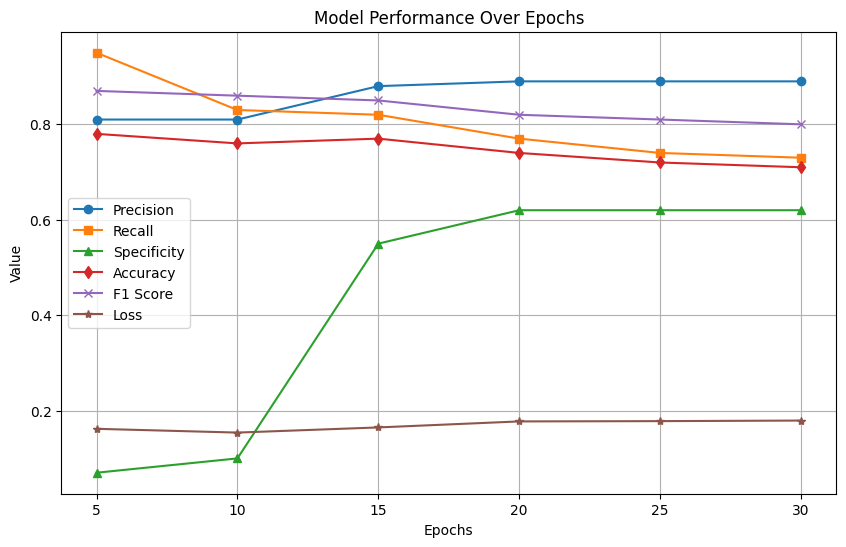

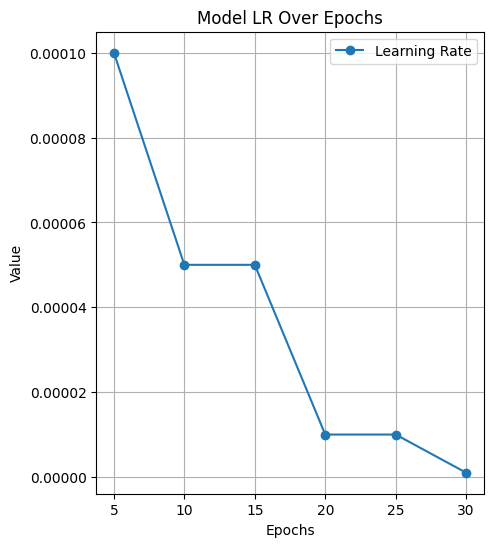

In [69]:
import matplotlib.pyplot as plt

epochs = [5, 10, 15, 20, 25, 30]
precision = [0.81, 0.81, 0.88, 0.89, 0.89, 0.89]
recall = [0.95, 0.83, 0.82, 0.77, 0.74, 0.73]
specificity = [0.07, 0.10, 0.55, 0.62, 0.62, 0.62]
accuracy = [0.78, 0.76, 0.77, 0.74, 0.72, 0.71]
f1_score = [0.87, 0.86, 0.85, 0.82, 0.81, 0.80]
loss = [0.1620, 0.1541, 0.1649, 0.1775, 0.1781, 0.1793]

learning_rate = [1e-4, 5e-5, 5e-5, 1e-5, 1e-5, 1e-6]

plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, marker='o', linestyle='-', label='Precision')
plt.plot(epochs, recall, marker='s', linestyle='-', label='Recall')
plt.plot(epochs, specificity, marker='^', linestyle='-', label='Specificity')
plt.plot(epochs, accuracy, marker='d', linestyle='-', label='Accuracy')
plt.plot(epochs, f1_score, marker='x', linestyle='-', label='F1 Score')
plt.plot(epochs, loss, marker='*', linestyle='-', label='Loss')

plt.title('Model Performance Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.xticks(epochs)

plt.grid()

plt.figure(figsize=(5, 6))
plt.plot(epochs, learning_rate, marker='o', linestyle='-', label='Learning Rate')
plt.title('Model LR Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.xticks(epochs)

plt.grid()
plt.show()